
# tSNE!

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import sys
sys.path.append(os.path.realpath(".."))
import tools
import EnergyFlow.ef_tools as ef_tools
import numpy as np

with open("../filepath.txt", 'r') as f:
    filename = f.read().strip("\n")   

# load data
if False: #os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file(filename, njets=10)
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)

Using TensorFlow backend.


padding arrays
done padding
777150 events total
444528 events after ensuring first 3 are correctly tagged
307055 events after ensuring we only have 3 tags
303931 events after ensuring there is at most 1 untagged jet


Loading model... 
Using architecture: ../models/architecture_2b.json 
and weights: ../models/weights_2b.h5
303931


100%|██████████| 303931/303931 [00:02<00:00, 137757.92it/s]


overall accuracy: 72.35 percent
ignoring 0.0 percent of 303931 events


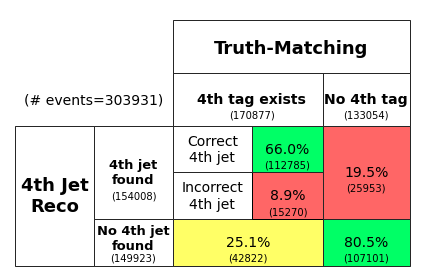

In [2]:
import importlib
import ptetaphi_nn
import awkward
import uproot_methods as urm

importlib.reload(ptetaphi_nn)

events = awkward.Table()
# add data to table
events['resolved_lv'] = urm.TLorentzVectorArray.from_ptetaphie(X[:,:,0], X[:,:,1], X[:,:,2],X[:,:,3])
truths = y[:,:-1].copy().astype(int)
truths[:,:3] = 1 
events['truth'] = truths  # no no-jet jet
tags = X[:,:,4]
events['tag'] = tags

nn = ptetaphi_nn.PtEtaPhiNN(events, load=("../models/architecture_2b.json", "../models/weights_2b.h5"), njets=X.shape[1], print_csv=False)

print(len(events))

selections = nn.evaluate(events, print_csv=False)

In [ ]:
n=1000

import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)

tsne = TSNE(perplexity=10, verbose=True, learning_rate=1, n_iter=100000)
# :n so this doesn't take eons
x_2d = np.array([x.flatten() for x in X])[:n, :]


pt = X[:,:,0]
njets = np.count_nonzero(pt, axis=1)
categories = [0 if n==4 else 1 for n in njets]


X_embedded = tsne.fit_transform(x_2d)
print(X_embedded.shape)


d = {
        0: "njets=4",
        1: "!=4",
    }
cat_words = np.array([d[c] for c in categories])

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cat_words[:n], legend='full', palette=palette)

In [ ]:
# filter for a bubble:
bubble = (X_embedded[:,0] < 70) & (-25 < X_embedded[:,1]) & (X_embedded[:,1] < 5)

print(bubble)

sns.scatterplot(X_embedded[bubble], X_embedded[bubble], hue=cat_words[:len(bubble)], legend='full', palette=palette)


bub_events = events[bubble]

